In [2]:
import datetime
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
import matplotlib
 
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

sns.set_style('whitegrid')
        
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160

In [3]:
 ml_data_path = 'log_corredor.csv'

In [4]:
ml_data = pd.read_csv(ml_data_path, skiprows=4)

print(len(ml_data))

11793


In [5]:
def to_seconds(hours):
    [hours, minutes, seconds] = [int(x) for x in hours.split(':')]
    x = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
    return x.seconds

rele1_timestamps_activated = [ data[0].split()[0] for index, data in ml_data.iterrows() if data[50] == 1]
rele1_hours_activated = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data[50] == 1]
rele1_hours_turned_on = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele1'] == 1]
rele1_hours_turned_off = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele1'] == 0]
print(len(rele1_timestamps_activated))
print(len(rele1_hours_turned_on))

rele2_timestamps_activated = [ data[0].split()[0] for index, data in ml_data.iterrows() if data[52] == 1]
rele2_hours_activated = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data[52] == 1]
rele2_hours_turned_on = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele2'] == 1]
rele2_hours_turned_off = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele2'] == 0]
print(len(rele2_timestamps_activated))
print(len(rele2_hours_turned_on))

238
3766
202
2450


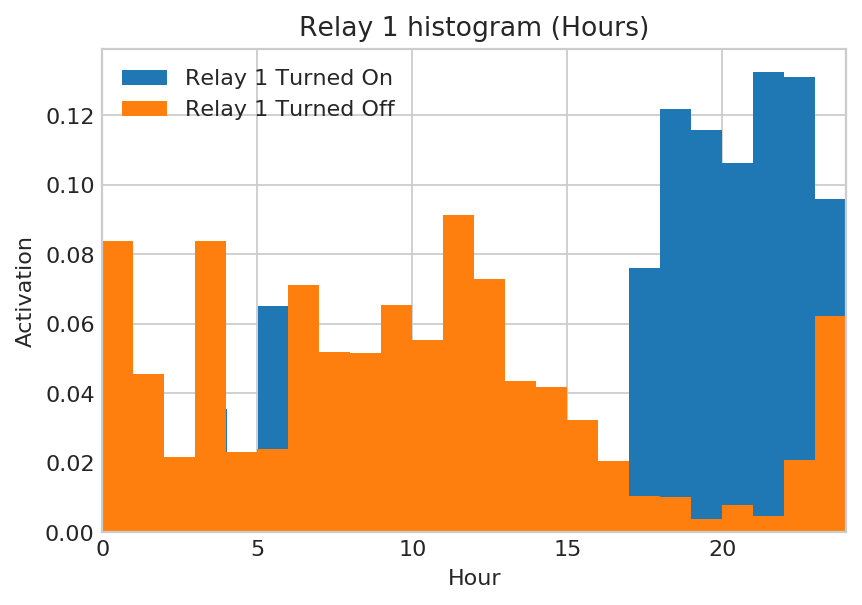

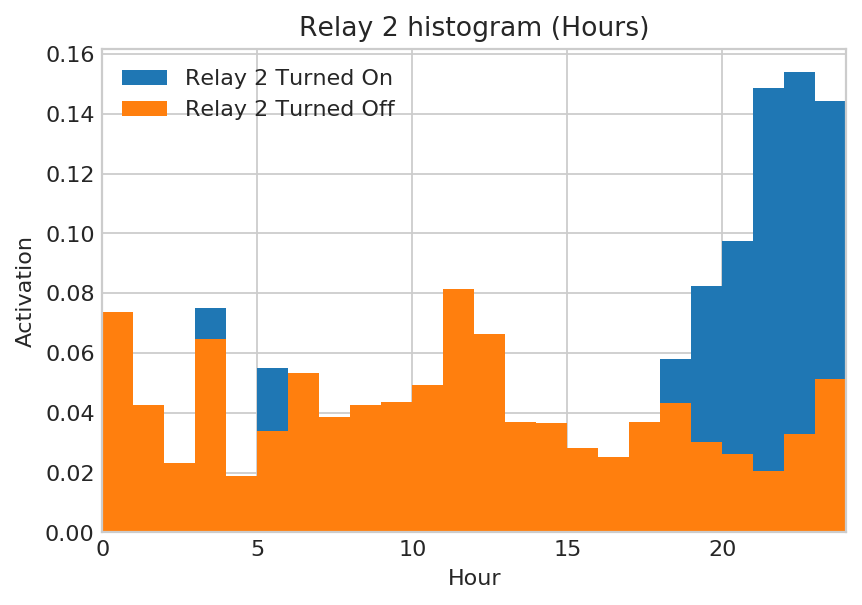

In [9]:
rele1_only_hours_turned_on = [hour/3600 for hour in rele1_hours_turned_on]
rele1_only_hours_turned_off = [hour/3600 for hour in rele1_hours_turned_off]
plt.xlim(0, 24)
plt.hist(rele1_only_hours_turned_on, bins=24, normed=True, label = 'Relay 1 Turned On')
plt.hist(rele1_only_hours_turned_off, bins=24, normed=True, label = 'Relay 1 Turned Off')
plt.title('Relay 1 histogram (Hours)')
plt.xlabel('Hour')
plt.ylabel('Activation')
plt.legend()
plt.show()

rele2_only_hours_turned_on = [hour/3600 for hour in rele2_hours_turned_on]
rele2_only_hours_turned_off = [hour/3600 for hour in rele2_hours_turned_off]
plt.xlim(0, 24)
plt.hist(rele2_only_hours_turned_on, bins=24, normed=True, label = 'Relay 2 Turned On')
plt.hist(rele2_only_hours_turned_off, bins=24, normed=True, label = 'Relay 2 Turned Off')
plt.title('Relay 2 histogram (Hours)')
plt.xlabel('Hour')
plt.ylabel('Activation')
plt.legend()
plt.show()

In [41]:
data = ml_data.iloc[28]
print(data)

Dado Bruto Unix Time                 1505058063 Web1 acionado
Dado Bruto DateTime                           10/9/17 12:41:3
Dado Bruto                  10/09/2017 12:41:03 Web1 acionado
Data                                               10/09/2017
Hora                                                 12:41:03
Info                                            Web1 acionado
ChipId                                                    NaN
Versao =                                              170906b
Unnamed: 8                                                  0
localPingErrCnt:                                          NaN
WiFi Conectando                                             0
WL_DISCONNECTED                                           NaN
minFreeHeap                                               NaN
ms                                                        NaN
NTP Server                                                  0
TimeNTP                                                     0
tempo pa

In [10]:
luminosity_right_before_rele1_turn_on = [ data[24] 
                                         for index, data in ml_data.iterrows() 
                                         if ml_data.iloc[index-1]['Rele1'] == 0 and data[50] == 1]
# print(luminosity_right_before_rele1_turn_on)
print(len(luminosity_right_before_rele1_turn_on))

118


In [11]:
features_rele1_turn_on = [[data[24], to_seconds(data[4])] 
                          for index, data in ml_data.iterrows() 
                          if ml_data.iloc[index-1]['Rele1'] == 0 and data[50] == 1]
# print(features_rele1_turn_on)
print(len(features_rele1_turn_on))

features_rele2_turn_on = [[data[24], to_seconds(data[4])] 
                          for index, data in ml_data.iterrows() 
                          if ml_data.iloc[index-1]['Rele2'] == 0 and data[52] == 1]
print(len(features_rele2_turn_on))

118
100


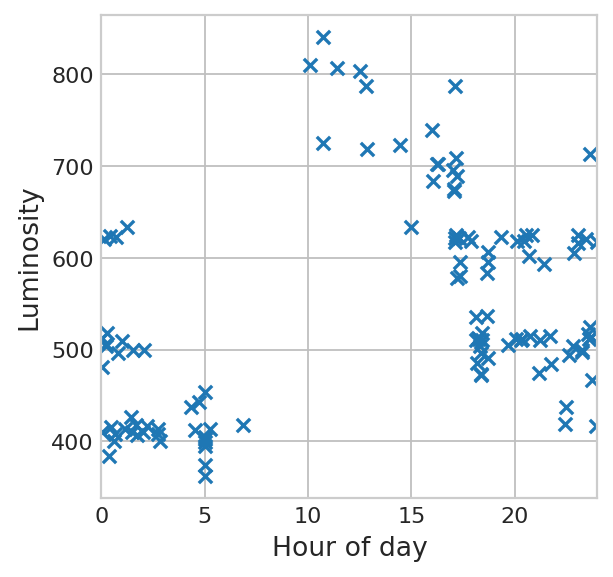

In [16]:
features_rele1_turn_on = np.array(features_rele1_turn_on)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hour of day",fontsize=12)
ax.set_ylabel("Luminosity",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(features_rele1_turn_on[:, 1]/3600, 
           features_rele1_turn_on[:, 0], 
           marker = 'x');

plt.show()

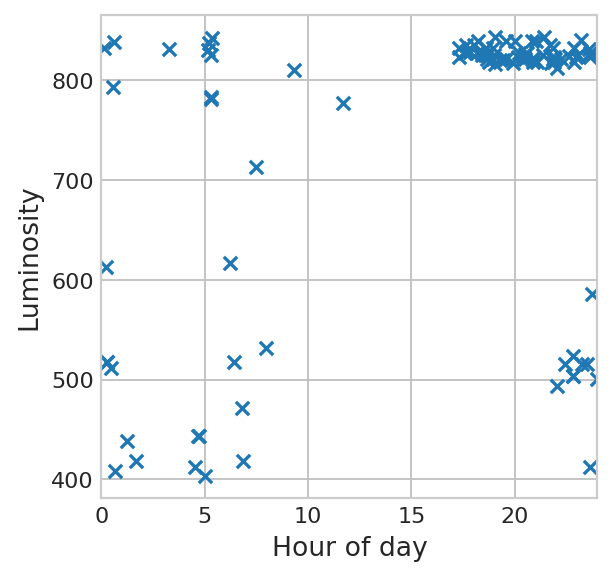

In [17]:
features_rele2_turn_on = np.array(features_rele2_turn_on)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hour of day",fontsize=12)
ax.set_ylabel("Luminosity",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(features_rele2_turn_on[:, 1]/3600, 
           features_rele2_turn_on[:, 0], 
           marker = 'x');

plt.show()